In [39]:
# Lets go back over the weather classification task with PyTorch
# I'll be creating a new virtual env "wx_class_env" for this using Python 3.10

# Also, this will be done in a Docker container instead... 

In [40]:
"""
Develop a CNN that accomplishes the following tasks:
    1) Classifies different weather phenomena of at least 4 different classes
    2) Achieves an accuracy of at least 80% (high precision)
    3) Makes use of pre-created architectures like ResNet, AlexNet, VGG, and any others
    4) Create a model from scratch as well
""";

In [41]:
# Torch check
import torch

print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Type: {torch.cuda.get_device_name(0)}")

ModuleNotFoundError: No module named 'torch'

### Data Collection

In [42]:
# Packages
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import random

In [43]:
# Start by accessing the data and opening some images
img_pth = "C:/Users/colts/OneDrive/Desktop/Python_Projects/Neural_Networks/Computer Vision/" \
    "ImageClassification/Image_Data/WeatherImages" 

img_folders = os.listdir(img_pth)

# Define image type
ext = ['jpg', 'jpeg']

# Show image types in folders - Should have a wide variety to choose from
print(img_folders)
print(f"Total unique weather types available: {len(img_folders)}")

['cloudy', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total unique weather types available: 12


In [44]:
# Collect images and their respective labels
def CollectImages(PATH, folder, image_ext, dspl_cnt=0):
    images = []
    for ext in image_ext:
        for file in glob.glob(PATH + "/" + folder + '/*.' + ext):
            # Using Pillow to reshape and convert the images
            images.append(file)

    if dspl_cnt == 1:
        # Displays number of images in each folder
        print(f"Number of Images in folder {folder}: {len(images)}")
    
    # Shuffles for randomness
    np.random.shuffle(images)
    
    # Returns the list of images along with an index of values that changes each run
    return images, np.array([folder for i in range(len(images))])

In [45]:
%%time

# Load in the images
images, added_labels = [], []
images_dict = {}

for file in img_folders:
    # To show the number of images per folder, change the 'dspl_cnt' to a 1
    image, label = CollectImages(img_pth, file, ext, dspl_cnt=1)
    images_dict[file] = label.shape[0]
    images.extend(image)
    added_labels.extend(label)

# Building series for the dataframe 
image_paths = pd.Series(images, name='Images').astype(str)
labels_for_image = pd.Series(added_labels, name='Class')

# Building dataframe
img_df = pd.concat([image_paths, labels_for_image], axis=1)
img_df = img_df.sample(frac=1).reset_index(drop=True)

Number of Images in folder cloudy: 310
Number of Images in folder dew: 698
Number of Images in folder fogsmog: 851
Number of Images in folder frost: 475
Number of Images in folder glaze: 639
Number of Images in folder hail: 591
Number of Images in folder lightning: 377
Number of Images in folder rain: 526
Number of Images in folder rainbow: 232
Number of Images in folder rime: 1160
Number of Images in folder sandstorm: 692
Number of Images in folder snow: 621
CPU times: total: 31.2 ms
Wall time: 55.4 ms


In [46]:
# Sample of the dataframe
img_df.sample(5)

,Images,Class
3439,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost
11,C:/Users/colts/OneDrive/Desktop/Python_Project...,sandstorm
4533,C:/Users/colts/OneDrive/Desktop/Python_Project...,rain
6743,C:/Users/colts/OneDrive/Desktop/Python_Project...,glaze
1026,C:/Users/colts/OneDrive/Desktop/Python_Project...,dew


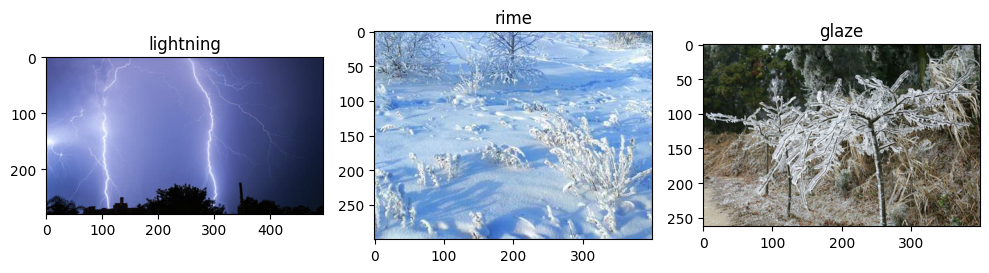

In [47]:
# Randomly select a set of 3 images to display from some folders - can add to a df

rand_int_1, rand_int_2, rand_int_3 = \
    random.randint(0, len(img_df)), random.randint(0, len(img_df)), random.randint(0, len(img_df))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
ax[0].imshow(plt.imread(img_df["Images"][rand_int_1]))
ax[0].set_title(img_df["Class"][rand_int_1])

ax[1].imshow(plt.imread(img_df["Images"][rand_int_2]))
ax[1].set_title(img_df["Class"][rand_int_2])

ax[2].imshow(plt.imread(img_df["Images"][rand_int_3]))
ax[2].set_title(img_df["Class"][rand_int_3])
plt.tight_layout()

### Data Exploration

In [48]:
# Basic EDA to get a sense of what we're looking at...
"""
What goes into our EDA?:
    1) Get a sense of the number of images we're working with
    2) It would be great to get the size of the largest & smallest images in the dataset
    3) How's the data spread? Are some folders larger than others?
""";

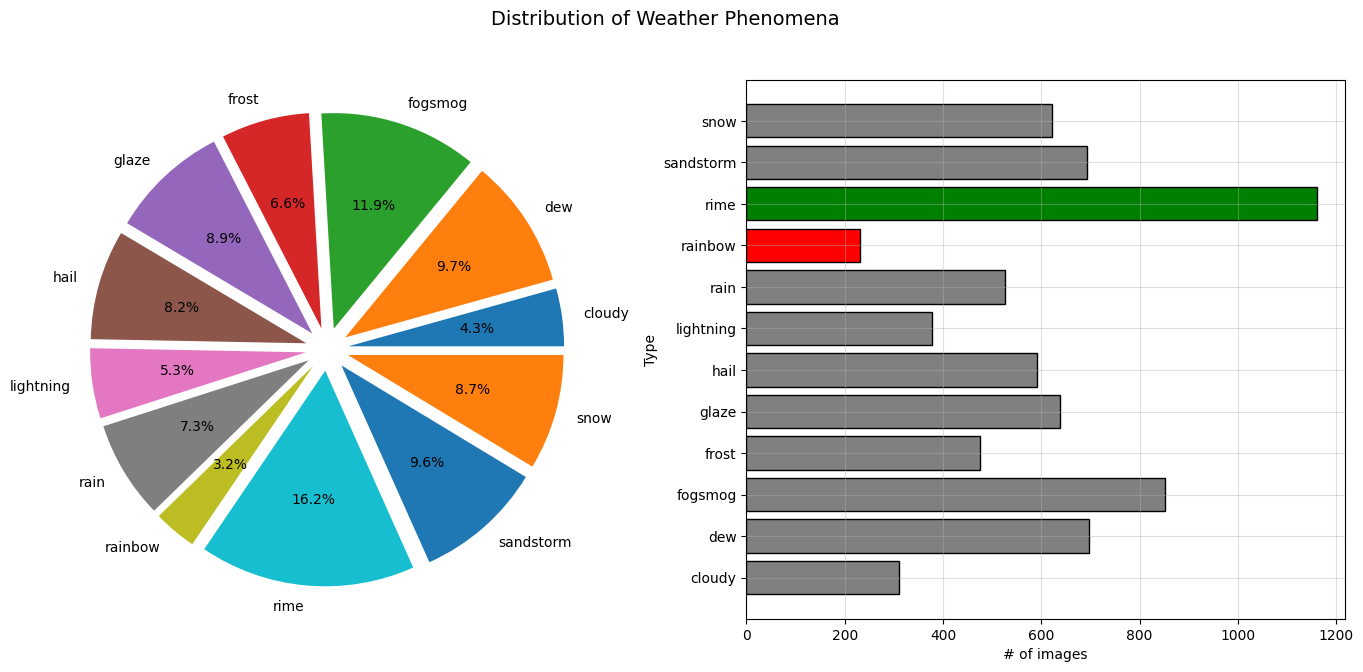

In [49]:
# Look at the number of images per folder - use df

# Build a visual, pie chart works since we want to see the whole also
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

###############################################################################

# Calculates the percent of the whole
def percent(x):
    val = round(x, 1)
    return f"{val}%"

explode_piece = [0.1] * len(img_folders)
ax[0].pie(images_dict.values(), labels=images_dict.keys(), textprops=dict(color="black"), 
        explode=explode_piece, autopct=lambda x: percent(x));

###############################################################################

img_dict_lst = list(images_dict.values())

# Color the max & min values accoridingly
max_val = img_dict_lst.index(max(img_dict_lst))
min_val = img_dict_lst.index(min(img_dict_lst))

colors = ['gray' if i != max_val and i != min_val else ('green' if i == max_val else 'red') 
            for i in range(len(img_dict_lst))]

# Creates a horizontal bar chart
ax[1].barh(list(images_dict.keys()), list(images_dict.values()), edgecolor="black", color=colors)
ax[1].grid(alpha=0.4)
ax[1].set_ylabel("Type")
ax[1].set_xlabel("# of images")

###############################################################################

plt.suptitle("Distribution of Weather Phenomena", color="black", size=14);

In [50]:
# Function for extracting image dimensions
def dimensions(pth):
    img = Image.open(pth)
    w, h = img.size

    # Total pixels
    tot = w * h

    # Return the dimensions
    return w, h, tot

In [51]:
from PIL import Image

# Find the largest and smallest images in the dataset
img_df["dimensions"] = img_df["Images"].apply(lambda pth: dimensions(pth))
img_df[["width", "height", "pixel_total"]] = img_df["dimensions"].apply(pd.Series)

In [52]:
# Drop the 'dimensions" column
img_df = img_df.drop(["dimensions"], axis=1)

In [53]:
# We can sort by a variety of dimension attributes now
img_df = img_df.sort_values(by=["pixel_total"], ascending=False).reset_index(drop=True)

In [54]:
img_df.sample(5)

,Images,Class,width,height,pixel_total
1239,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost,751,501,376251
5278,C:/Users/colts/OneDrive/Desktop/Python_Project...,snow,426,240,102240
2039,C:/Users/colts/OneDrive/Desktop/Python_Project...,snow,480,319,153120
5573,C:/Users/colts/OneDrive/Desktop/Python_Project...,dew,400,250,100000
7030,C:/Users/colts/OneDrive/Desktop/Python_Project...,rainbow,314,124,38936


In [55]:
# Why are dimensions important? Since we'll need to do some re-sizing to make all images fit the same, we'll want to 
# get an ideas as to which categories will be the most impacted

# As I initally mentioned, I'll only be picking a handful of image classes to start, I'll randomly select ~250
# or so images from each folder to use in the model. 
# This is done to help battle data imbalance.

In [56]:
# Final component is shrinking the dataset to incorporate my requirements for the model
# Create a copy
img_df_modeling = img_df.copy()

In [57]:
# I want to incorporate at least 250 images of each class, for at least 4 classes
img_df_modeling = img_df_modeling.sort_values(by=["Class"]).reset_index(drop=True)

# I will also drop all 'rainbow' values as that class contains the least amount of images by a 
# sizable margin...
img_df_modeling = img_df_modeling[img_df_modeling["Class"] != "rainbow"]

In [79]:
# Trimming the classes down to 6 - Start with 6 key meteorological phenomena
img_df_new = img_df_modeling[(img_df_modeling["Class"] == "cloudy") | (img_df_modeling["Class"] == "rain") 
    | (img_df_modeling["Class"] == "lightning") | (img_df_modeling["Class"] == "frost") | (img_df_modeling["Class"] == "hail") 
    | (img_df_modeling["Class"] == "snow")].reset_index(drop=True);

# This updates as we introduce (or remove) classes...
img_modeling_lst = list(img_df_new.groupby(["Class"]).count()["Images"])

In [80]:
# Using pandas functionality here to create another df...
smpl = min(img_modeling_lst)
imgs = img_df_new.groupby(["Class"]).apply(lambda x: x.sample(smpl, replace=False)).reset_index(drop=True)

# Now we have a slimmer dataset with evenly split data for training. This also gives the the option to add more images
# to classes and the dataframe will always update to the least populated class

# I'll be trimming this down by going down to 6 classes for now rather than 11.

C:\Users\colts\AppData\Local\Temp\ipykernel_70128\1899990212.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  imgs = img_df_new.groupby(["Class"]).apply(lambda x: x.sample(smpl, replace=False)).reset_index(drop=True)


In [83]:
# Showcase count per class
imgs.groupby(["Class"]).count()

,Images,width,height,pixel_total
Class,,,,
cloudy,310,310,310,310
frost,310,310,310,310
hail,310,310,310,310
lightning,310,310,310,310
rain,310,310,310,310
snow,310,310,310,310


In [84]:
# Sample the data
imgs.sample(10)

,Images,Class,width,height,pixel_total
530,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost,450,321,144450
1398,C:/Users/colts/OneDrive/Desktop/Python_Project...,rain,400,329,131600
920,C:/Users/colts/OneDrive/Desktop/Python_Project...,hail,400,308,123200
50,C:/Users/colts/OneDrive/Desktop/Python_Project...,cloudy,269,168,45192
353,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost,400,299,119600
522,C:/Users/colts/OneDrive/Desktop/Python_Project...,frost,1200,1600,1920000
1463,C:/Users/colts/OneDrive/Desktop/Python_Project...,rain,400,264,105600
1784,C:/Users/colts/OneDrive/Desktop/Python_Project...,snow,1920,799,1534080
135,C:/Users/colts/OneDrive/Desktop/Python_Project...,cloudy,852,480,408960
188,C:/Users/colts/OneDrive/Desktop/Python_Project...,cloudy,242,161,38962


In [95]:
# Unhash this to use as an image checker...
"""
x = random.randint(0, len(imgs))

plt.figure(figsize=(10,5))
plt.imshow(plt.imread(imgs["Images"].iloc[x]))
""";

### Building the Dataset

In [63]:
# Converting the raw images to a PyTorch-acceptable dataset...